# Vehicle Route Planning

## Packages

In [1]:
## Data Acess and Manipulation
import json
import numpy as np
import pandas as pd
import snowflake.connector as sf

# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

## for vehicle route planning
from ortools.constraint_solver import pywrapcp
from ortools.constraint_solver import routing_enums_pb2

## Utilities
import os
import logging
from functools import partial
#from google.colab import userdata
from multiprocessing import cpu_count
from concurrent.futures import ProcessPoolExecutor as Executor

## Geospatial Work
import folium
from folium import plugins
import osmnx as ox
import networkx as nx
from shapely.geometry import shape, Point
from math import sin, cos, sqrt, atan2, radians

## Multiprocessing
from multiprocessing import Pool, cpu_count

## Utilities
### importing necessary functions from dotenv library and loading variables from .env file
import os
from dotenv import load_dotenv 
load_dotenv()

True

In [2]:
# Notebook Configurations
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Data


### Item Weights Master

In [3]:
# Weights Master
df_weights = pd.read_excel(
    r'assets\data\Item Weight.xlsx'
    )

print(f"Shape of the imported dataset is: {df_weights.shape}")
df_weights.head(5)

Shape of the imported dataset is: (677, 2)


,itemCode,itemWeight
0,GOSF0001,10.6
1,DBRF0006,0.1
2,AEHG0009,1.0
3,GRND0001,0.4
4,ULPL0014,1.0


### Order (Line Level)

In [4]:
data_query = '''
        WITH
        entries as
        (   select
                regexp_replace("SOURCE NO_", '[A-Z]') AS "customerCode",
                "ITEM LEDGER ENTRY NO_" as "itemLedgerEntryNo",
                "EXTERNAL DOCUMENT NO_" AS "externalDocumentNo",
                "ITEM NO_" AS "itemCode",
                "DESCRIPTION" as "itemDescription",
                "LOCATION CODE" as "locationCode",
                "O ITEM LEDGER ENTRY QUANTITY"*-1 as "invoiceQuantity",
                "O SALES AMOUNT" as "saleValue",
                "O COST AMOUNT" as "costValue",
                MIN("O DOCUMENT DATE") OVER (PARTITION BY "EXTERNAL DOCUMENT NO_") as "invoiceDate"
            from buygro.ads.adj_vle
            where "O DOCUMENT DATE" = '2024-04-03' --CURRENT_DATE()
        ),
        customer_details as
        (
            select distinct
                "ecvId",
                "erpId",
                "source",
                "name",
                replace(parse_json("details"):city, '"', '') as "city",
                replace(parse_json("details"):region, '"', '') as "region",
                replace(parse_json("details"):address, '"', '') as "address",
                parse_json("details"):location:lat as "lattitude",
                parse_json("details"):location:long as "longitude"
            from buygro.raw_ecv.bg_ecv_users
        ),
        item_details as
        (
            select
                item_code,
                description,
                min(physical_wt/physical_qty) as item_weight
            from BUYGRO.RAW.AFSYS_V_STK_DETAIL_WITH_DMG_DETAILS
            where customer = 'BUYGRO'
            and bin <> 'DESBIN'
            group by 1, 2
        )
        select
            b."name" as "customerName",
            b."source" as "customerSource",
            b."city" as "customerCity",
            b."region" as "customerRegion",
            b."address" as "customerAddress",
            b."lattitude" as "customerLat",
            b."longitude" as "customerLong",
            c.item_weight as "itemWeight",
            c.item_weight*"invoiceQuantity" as "itemTotalWeight",
            a.*
        from entries as a
        left join customer_details as b on a."customerCode" = b."ecvId"
        left join item_details as c on a."itemCode" = c.item_code

'''

In [5]:
conn = sf.connect(
    user=os.getenv("sf_user"),
    password=os.getenv("sf_pwd") ,
    account=os.getenv("sf_account") ,
    database='BUYGRO',
    warehouse='BUYGRO_ANALYSIS',
    schema='RAW_ECV'
)

cur = conn.cursor()
cur.execute(data_query)
df = pd.DataFrame(cur.fetchall(), columns=[x[0] for x in cur.description])
cur.close()
conn.close()

print(f"Shape of the imported dataset is: {df.shape}")

Shape of the imported dataset is: (3026, 19)


### ADS

In [6]:
# Copy
df_copy = df.copy()

# Merge weights master with orders
df = df.merge(df_weights, on='itemCode', how='left')
df['itemWeight'] = np.where(df.itemWeight_y.isna(), df.itemWeight_x, df.itemWeight_y)
df.drop(['itemWeight_x', 'itemWeight_y','itemTotalWeight'], axis=1, inplace=True)
df['invoiceQuantity'] = df['invoiceQuantity'].astype(float)
df['saleValue'] = df['saleValue'].astype(float)
df['costValue'] = df['costValue'].astype(float)
df['itemTotalWeight'] = df['itemWeight']*df['invoiceQuantity']
df.head(5)

,customerName,customerSource,customerCity,customerRegion,customerAddress,customerLat,customerLong,customerCode,itemLedgerEntryNo,externalDocumentNo,itemCode,itemDescription,locationCode,invoiceQuantity,saleValue,costValue,invoiceDate,itemWeight,itemTotalWeight
0,ZAINAB GROCERY,mobile,Ajman,Ajman,Nuaimiyah 1 Al Enjaaz Street Ajman,25.37995077,55.45546307,14807,1885725,20352326,ARLA0008,"Kraft Cheddar Cheese Can, 100 gm",NIP,4.0,14.48,-13.67,2024-04-03,1.0,4.0
1,ARDH AL SALAM GROCERY,SalescoutApp,Qasimiya,Sharjah,"26 St - Al Qasimia - Al Mahatah, Near Everyday...",25.2489204,55.3060550999999,20221695,1883367,20351951,ARLA0008,"Kraft Cheddar Cheese Can, 100 gm",NIP,3.0,10.86,-10.25,2024-04-03,1.0,3.0
2,BAQALA ALHANAN OASIS,mobile,Abu Dhabi,Abu Dhabi,Shabiya 12 6 يدالة - Mohamed Bin Zayed City - ...,24.3186035,54.5372453,6286,1883769,20352025,ARLA0008,"Kraft Cheddar Cheese Can, 100 gm",NIP,6.0,21.39,-20.50,2024-04-03,1.0,6.0
3,NEW ZUBAID SUPERMARKET,mobile,Kalba,Fujairah,"Kalba Fuajirah, Near Falcon Pack",25.07622899,56.35626177,18136,1883334,20351948,ARLA0008,"Kraft Cheddar Cheese Can, 100 gm",NIP,12.0,42.79,-41.00,2024-04-03,1.0,12.0
4,AL NOUKHADA GROCERY- L L C,SalescoutApp,Muroor Road,Abu Dhabi,Khaleefa University Shakhbout Bin Sultan St - ...,24.4440783333333,54.3975683333333,20221179,1885156,20352233,ARLA0008,"Kraft Cheddar Cheese Can, 100 gm",NIP,25.0,90.50,-85.41,2024-04-03,1.0,25.0


In [7]:
# load GeoJSON file containing sectors
with open(r'assets\data\GeoPloygon Data\GeoJSON\boundary-polygon-lvl2.geojson') as f:
    js = json.load(f)

def point_in_poly(js, latitude, longitude):
    try:
        point = Point(longitude, latitude)
    except TypeError:
        return (latitude, longitude)
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return True

df['customLocValidFlg'] = df.apply(lambda x: point_in_poly(js, x['customerLat'], x['customerLong']), axis=1)

In [8]:
# Placeholder to enrcich the data using geojson information

In [9]:
print(f"Shape of data queried: {df.shape}")

print(f"Total number of rows associated to returns: {df[df['invoiceQuantity'] < 0].shape} will be dropped\n")
df.drop(df[df['invoiceQuantity'] < 0].index, inplace=True)

print(f"Total Number of rows with null weight: {df['itemWeight'].isna().sum(axis=0)} will be dropped\n")
df[df['itemWeight'].isna()]
df.dropna(subset=['itemWeight'], inplace=True)

print(f"Total Number of rows with null customer location: {df[(df['customerLong'] == '0') & (df['customerLat'] == '0')].shape} will be dropped\n")
df.drop(df[(df['customerLong'] == '0') & (df['customerLat'] == '0')].index, inplace=True)

print(f"Total Number of rows with incorrect location {df[df['customLocValidFlg'] != True].shape} will be dropped\n")
df.drop(df[df['customLocValidFlg'] != True].index, inplace=True)

print(f"Shape of data after preprocessing: {df.shape}")

Shape of data queried: (3026, 20)
Total number of rows associated to returns: (107, 20) will be dropped

Total Number of rows with null weight: 8 will be dropped

Total Number of rows with null customer location: (10, 20) will be dropped

Total Number of rows with incorrect location (0, 20) will be dropped

Shape of data after preprocessing: (2901, 20)


## Exploration

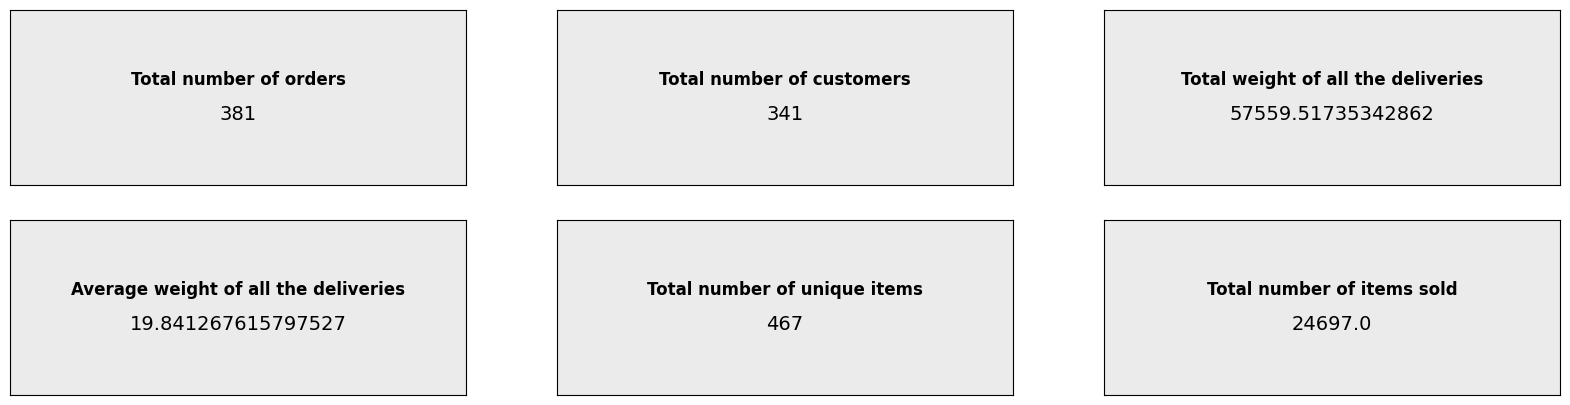

In [10]:
# Placeholder cells for some exploratory statistics
def key_iterator(item):
    """
    Creates an iterator over the dictionary keys.
    """
    return iter(item)

def get_next_key(key_iter):
    """
    Returns the next key from the key iterator.
    If all keys have been iterated, it restarts from the beginning or raises StopIteration.
    """
    try:
        return next(key_iter)
    except StopIteration:
        # Uncomment the following line if you want to restart the iteration once all keys are iterated
        # key_iter = iter(dictionary.keys())
        raise StopIteration("No more keys to iterate.")

def create_kpi_box(ax, title, value, color):
    # Use the entire axes to draw the rectangle
    ax.add_patch(Rectangle((0, 0), 1, 1, color=color, alpha=0.3, transform=ax.transAxes))

    # Add text
    ax.text(0.5, 0.6, title, ha='center', va='center', fontsize=12, fontweight='bold', transform=ax.transAxes)
    ax.text(0.5, 0.4, value, ha='center', va='center', fontsize=14, transform=ax.transAxes)

    # Remove the x and y ticks
    ax.set_xticks([])
    ax.set_yticks([])

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,5))


df_metrics = {
    "Total number of orders": df['externalDocumentNo'].nunique(),
    "Total number of customers": df['customerCode'].nunique(),
    "Total weight of all the deliveries": df['itemTotalWeight'].sum(),
    "Average weight of all the deliveries": df['itemTotalWeight'].mean(),
    "Total number of unique items": df['itemCode'].nunique(),
    "Total number of items sold": df['invoiceQuantity'].sum()
    }

key_iter = key_iterator(df_metrics.keys())

for row in range(2):
    for col in range(3):
        try:
            key = get_next_key(key_iter)
            create_kpi_box(ax[row,col], key, f"{df_metrics[key]}", 'silver')
        except StopIteration:
            break

In [11]:
order_details = df.groupby(['customerCode', 'customerName', 'customerAddress', 'customerRegion', 'customerLat', 'customerLong']).agg(
    {
        'externalDocumentNo': lambda x: pd.Series.nunique(x),
        'itemTotalWeight': 'sum',
        'itemCode': lambda x: pd.Series.nunique(x),
        'invoiceQuantity': 'sum',
        'saleValue': 'sum',
        'costValue': 'sum'
        }
    ).reset_index().copy()
order_details.rename(
    columns={
        'externalDocumentNo': 'totalOrders',
        'itemTotalWeight': 'totalWeight',
        'itemCode': 'totalItems'
        },
    inplace=True
    )
order_details.head()

,customerCode,customerName,customerAddress,customerRegion,customerLat,customerLong,totalOrders,totalWeight,totalItems,invoiceQuantity,saleValue,costValue
0,10000,AL NADA GROCERY-SOLE PROPRIETORSHIP LLC,Delma Street Opp Zayed University Ewan Curtin ...,Abu Dhabi,24.4648216666666,54.3827283333333,2,42.46,4,55.0,287.71,-278.71
1,10028,EPEE BAQALA,57 A˜a A˜a A˜a A˜a A˜a A™a€za˜a A™a A˜a A™a A™...,Abu Dhabi,24.4795116666666,54.3590733333333,2,178.90,13,102.0,339.00,-326.90
2,10036,ABU MOOSA GROCERY,Dibba Fujairah Near Al Marwa Supermarket,Fujairah,25.5935375,56.2727644,1,10.36,4,27.0,148.96,-142.43
3,10103,Tawoon Al Madina Supermarket,Al Khan Mamzar Corniche Road Al Tawoon Sharjah,Sharjah,25.31704624,55.36484446,1,44.24,9,44.0,480.29,-456.43
4,10140,Fajer Al Khan Supermarket,Al Mawja Tower Al Tawoon Area Behind Sharjah I...,Sharjah,25.31747543,55.37543335,1,21.20,4,50.0,272.62,-267.00


In [12]:
# Gallega Cold Store
start = [24.931690466392208, 55.06185223067843]
order_details = df.groupby(['customerCode', 'customerName', 'customerAddress', 'customerRegion', 'customerLat', 'customerLong']
                            ).agg({
                                'externalDocumentNo': lambda x: pd.Series.nunique(x),
                                'itemTotalWeight': 'sum',
                                'itemCode': lambda x: pd.Series.nunique(x),
                                'invoiceQuantity': 'sum',
                                'saleValue': 'sum',
                                'costValue': 'sum'
                                }
                            ).reset_index().copy()
order_details.rename(columns={
                            'externalDocumentNo': 'totalOrders',
                            'itemTotalWeight': 'totalWeight',
                            'itemCode': 'totalItems'
                            }, 
                    inplace=True
                    )
order_details['invoiceQuantity'] = order_details['invoiceQuantity'].abs()
order_details['costValue'] = order_details['costValue'].abs()
order_details['grossProfit'] = order_details['saleValue'] - order_details['costValue']
order_details['grossProfitMargin'] = order_details['grossProfit'] / order_details['saleValue'] * 100
order_details['customerRegion'] = order_details['customerRegion'].str.upper()
order_details['totalWeight'] = order_details['totalWeight'].fillna(0) # Replace NaN values in the itemTotalWeight column with 0

# Adding base row
base_row = {'customerCode': 0000,'customerName': 'base', 'customerAddress': 'base', 'customerRegion': 'base', 'customerLat': start[0], 'customerLong': start[1]}
order_details = pd.concat([pd.DataFrame(base_row, index=[0]), order_details], ignore_index=True)
order_details["base"] = order_details["customerName"].apply(lambda x: 1 if x=='base' else 0)

In [13]:
# Gallega Cold Store
start = [24.931690466392208, 55.06185223067843]

# rolling up to Customer Level
order_details = df.groupby(['customerCode', 'customerName', 'customerAddress', 'customerRegion', 'customerLat', 'customerLong']).agg(
    {
        'externalDocumentNo': lambda x: pd.Series.nunique(x),
        'itemTotalWeight': 'sum',
        'itemCode': lambda x: pd.Series.nunique(x),
        'invoiceQuantity': 'sum',
        'saleValue': 'sum',
        'costValue': 'sum'
        }
    ).reset_index().copy()
order_details.rename(
    columns={
        'externalDocumentNo': 'totalOrders',
        'itemTotalWeight': 'totalWeight',
        'itemCode': 'totalItems'
        },
    inplace=True
    )
order_details['invoiceQuantity'] = order_details['invoiceQuantity'].abs()
order_details['costValue'] = order_details['costValue'].abs()
order_details['grossProfit'] = order_details['saleValue'] - order_details['costValue']
order_details['grossProfitMargin'] = order_details['grossProfit'] / order_details['saleValue'] * 100
order_details['customerRegion'] = order_details['customerRegion'].str.upper()

# Adding base row
base_row = {'customerCode': 0000,'customerName': 'base', 'customerAddress': 'base', 'customerRegion': 'base', 'customerLat': start[0], 'customerLong': start[1]}
order_details = pd.concat([pd.DataFrame(base_row, index=[0]), order_details], ignore_index=True)
order_details["base"] = order_details["customerName"].apply(lambda x: 1 if x=='base' else 0)


color = "base"  #color based on this column
lst_colors = ["black","red"]

# add colors
lst_elements = sorted(list(order_details[color].unique()))
order_details["color"] = order_details[color].apply(lambda x: lst_colors[lst_elements.index(x)])

In [14]:
# scaling total weight for visual
max_weight = order_details['totalWeight'].max()  # Find the maximum weight
min_radius = 5  # Minimum circle radius
max_radius = 20  # Maximum circle radius



In [15]:
# add markers
def html_popup(row):
    html = f"""
        <h3> Customer Details </h3><br>
        <ul>
        <li>Customer Code = {row['customerCode']}</li>
        <li>Customer Address = {row['customerAddress']}</li>
        <li>Total Orders = {row['totalOrders']}</li>
        <li>Total Order weight = {row['totalWeight']}</li>
        <li>Total Items = {row['totalItems']}</li>
        <li>Sale Value = {row['saleValue']}</li>
        <li>Gross Profit Margin = {row['grossProfitMargin']}</li>
        </ul>
        """
    return html

In [16]:
# Define a function to return an empty style
def style_function(feature):
    return {
        #'fillColor': 'rgba(255, 255, 0, 0.15)',  # Set fill color to none Yellow
        #'fillColor': 'rgba(0, 191, 255, 0.3)', # Set fill color to none llght blue
        'fillColor': 'rgba(65, 191, 225, 0.3)', # Set fill color to none royal blue
        'color': 'rgba(0, 0, 0, .8)',  # Set border color to none
        'weight': 0.35}

In [17]:
popup = ["customerCode",'customerAddress','totalOrders','totalWeight','totalItems','saleValue', 'grossProfitMargin'] #popup based on this column

# scaling total weight for visual
max_weight = order_details['totalWeight'].max()  # Find the maximum weight
min_radius = 5  # Minimum circle radius
max_radius = 20  # Maximum circle radius

# Function to calculate radius based on totalWeight
def calculate_radius(weight):
    # Simple linear scaling (you might want to adjust this based on your specific needs)
    if np.isnan(weight):
        return 5
    return min_radius + (weight / max_weight) * (max_radius - min_radius)

# base map
map_ = folium.Map(location=start, tiles="Cartodb Positron", zoom_start=12)

# geojson_data
geojson_data = r'assets\data\GeoPloygon Data\GeoJSON\boundary-polygon-lvl2.geojson'
popup_geo = folium.GeoJsonPopup(fields=["NAME_EN"])

# add geojson to map
folium.GeoJson(
    geojson_data,
    popup=popup_geo,
    style_function=style_function,  # Apply the empty style
).add_to(map_)

order_details.apply(
    lambda row: folium.CircleMarker(
        location=[
            row["customerLat"],
            row["customerLong"]
            ],
        popup=html_popup(row[popup]),
        color=row["color"],
        fill=True,
        fill_opacity = 0.6,
        opacity = 1,
        radius=calculate_radius(row['totalWeight']),
        stroke=False
        ).add_to(map_),
    axis=1
    )

# add full-screen button
plugins.Fullscreen(position="topright", title="Expand",
      title_cancel="Exit", force_separate_button=True).add_to(map_)

# show
map_

In [18]:
# Replace NaN values in the itemTotalWeight column with 0
order_details['totalWeight'].fillna(0, inplace=True)
order_details.head()

C:\Users\lakshmi.n.GAGROUP\AppData\Local\Temp\ipykernel_25072\2852424339.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  order_details['totalWeight'].fillna(0, inplace=True)


,customerCode,customerName,customerAddress,customerRegion,customerLat,customerLong,totalOrders,totalWeight,totalItems,invoiceQuantity,saleValue,costValue,grossProfit,grossProfitMargin,base,color
0,0,base,base,base,24.93169,55.061852,NaN,0.00,NaN,NaN,NaN,NaN,NaN,NaN,1,red
1,10000,AL NADA GROCERY-SOLE PROPRIETORSHIP LLC,Delma Street Opp Zayed University Ewan Curtin ...,ABU DHABI,24.4648216666666,54.3827283333333,2.0,42.46,4.0,55.0,287.71,278.71,9.00,3.128150,0,black
2,10028,EPEE BAQALA,57 A˜a A˜a A˜a A˜a A˜a A™a€za˜a A™a A˜a A™a A™...,ABU DHABI,24.4795116666666,54.3590733333333,2.0,178.90,13.0,102.0,339.00,326.90,12.10,3.569322,0,black
3,10036,ABU MOOSA GROCERY,Dibba Fujairah Near Al Marwa Supermarket,FUJAIRAH,25.5935375,56.2727644,1.0,10.36,4.0,27.0,148.96,142.43,6.53,4.383727,0,black
4,10103,Tawoon Al Madina Supermarket,Al Khan Mamzar Corniche Road Al Tawoon Sharjah,SHARJAH,25.31704624,55.36484446,1.0,44.24,9.0,44.0,480.29,456.43,23.86,4.967832,0,black


In [19]:
geojson_data= r'assets\data\GeoPloygon Data\GeoJSON\gadm41_ARE_2.json'
# load GeoJSON file containing sectors 
with open(geojson_data, encoding='utf-8') as f:
    js = json.load(f)

#Reading the GeoJson File as DF for processing
gdf = geopandas.read_file(geojson_data)
gdf = gdf[['GID_1','GID_2','NAME_1', 'NAME_2', 'geometry','TYPE_2','ENGTYPE_2']]

#Creating GeoPandas geometry
points_gdf_1 = geopandas.GeoDataFrame(df, geometry=geopandas.points_from_xy(df.customerLong, df.customerLat),crs=4326)

#Joining Points & locations (GeoJson)
joined_gdf_1 = geopandas.sjoin( points_gdf_1, gdf_1, how='left', predicate='within')
#joined_gdf = joined_gdf.head()

df_area_sales_1 = joined_gdf_1.groupby('GID_2').agg({'itemTotalWeight': 'sum'}).reset_index()


gdf_l2_IDs = gdf[['GID_2']]

# Merge the master DataFrame with your table using a left join
df_area_sales_2 = gdf_l2_IDs.merge(df_area_sales_1, on='GID_2', how='left')

# Replace NaN values in the itemTotalWeight column with 0
df_area_sales_2['itemTotalWeight'].fillna(0, inplace=True)

# Print the merged DataFrame with missing IDs added and itemTotalWeight set to 0
df_area_sales_2.head()


NameError: name 'geopandas' is not defined

In [ ]:
fig = px.choropleth(df_area_sales_2, 
                    geojson=js, 
                    locations="GID_2", 
                    featureidkey="properties.GID_2", 
                    color='itemTotalWeight',
                    color_continuous_scale="ylgn",  # Set color scale to green
                    range_color=(0, 1540),
                    scope='asia'
                   )

# Add points to the choropleth map
scatter_trace = px.scatter_geo(order_details, 
                               lat='customerLat', 
                               lon='customerLong', 
                               size='totalWeight',
                               color='totalWeight',
                               color_continuous_scale="Reds",  # Set color scale to red
                               opacity=.5,
                              )

scatter_trace.update_traces(marker=dict(color='Orange', size=15, line=dict(width=1, color='White')), selector=dict(mode='markers'))
fig.add_trace(scatter_trace.data[0])

# Update layout for better formatting
fig.update_layout(
    coloraxis_colorbar=dict(title='Weight Scale'),  # Adjust color bar title
    geo=dict(projection_type='mercator'  # Adjust projection type if necessary
            ),
    )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, plot_bgcolor='black')
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

In [ ]:


# Visualization
fig = px.choropleth(df_area_sales_2, geojson=js, locations="GID_2", featureidkey="properties.GID_2", color='itemTotalWeight',
                           color_continuous_scale="ylgn", # ylorbr, ylgnbu, ylgn, ylorrd, 'tempo', turbid_r, twilight_r
                           range_color=(0, 1540),
                           scope='asia'#,hover_data=["Revenue", "Name_1", "Type_2", "Name_2", "EngType_2"]
                          )
# Add points to the choropleth map
scatter_trace = px.scatter_geo(order_details, 
                             lat='customerLat', 
                             lon='customerLong', 
                             size='totalWeight',
                             color='totalWeight',
                             color_continuous_scale="Reds",
                             opacity=1,

                            )

scatter_trace.update_traces(marker=dict(line=dict(width=2, color='Orange')), selector=dict(mode='markers'))
fig.add_trace(scatter_trace.data[0])

# Update layout for better formatting
fig.update_layout(
    coloraxis_colorbar=dict(title='Weight Scale'),  # Adjust color bar title
    geo=dict(projection_type='mercator'  # Adjust projection type if necessary
            ),
    )

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, plot_bgcolor='black')
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

In [ ]:
# Visualization
fig = px.choropleth(df_area_sales_2, geojson=js, locations="GID_2", featureidkey="properties.GID_2", color='itemTotalWeight',
                           color_continuous_scale="ylgn", # ylorbr, ylgnbu, ylgn, ylorrd, 'tempo', turbid_r, twilight_r
                           range_color=(0, 1540),
                           scope='asia'#,hover_data=["Revenue", "Name_1", "Type_2", "Name_2", "EngType_2"]
                          )
# Add points to the choropleth map
fig.add_trace(px.scatter_geo(order_details, 
                             lat='customerLat', 
                             lon='customerLong', 
                             size='totalWeight',
                             color='totalWeight',
                             color_continuous_scale="Reds",
                             opacity=1,

                            ).data[0])

fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0}, plot_bgcolor='black')
fig.update_geos(fitbounds="locations", visible=False)
fig.show()

In [ ]:


# Create scatter_geo plot
fig = px.scatter_geo(order_details, lat='customerLat', lon='customerLong')
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.update_geos(fitbounds="locations", visible=False)

# Show the plot
fig.show()

In [ ]:
import plotly.express as px

# Assuming df_area_sales_1 contains your data
# Assuming 'L2 ID' contains the location IDs for the scatter plot
# Assuming x and y represent the coordinates for the scatter plot
# Assuming json_data contains your GeoJSON data for the polygons

# Visualization: Scatter plot with geospatial polygons
fig = px.scatter_geo(order_details, 
                      locationmode='ISO-3', 
                      lon='customerLong', 
                      lat='customerLat', 
                      color='totalWeight', 
                      color_continuous_scale='Viridis', 
                      title='Scatter Plot Graph with Geospatial Polygons'
                     )

#fig.update_geos(fitbounds="locations", visible=False) # Optional: fits the map to the points

fig.show()

ValueError: Value of 'lat' is not the name of a column in 'data_frame'. Expected one of ['latitude', 'longitude', 'weight'] but received: customerLat

## Distance Matrix

In [ ]:
print(cpu_count())

8


In [ ]:
class DistanceCalculator:
    def __init__(self, bbox=None, network_type="drive"):
        self.G = None
        self.bbox = bbox
        self.network_type = network_type

    def create_graph(self):
        if self.bbox is None:
            raise ValueError("Bounding box is not set.")
        north, south, east, west = self.bbox
        self.G = ox.graph_from_bbox(north, south, east, west, network_type=self.network_type)
        self.G = ox.add_edge_speeds(self.G)
        self.G = ox.add_edge_travel_times(self.G)
        logger.info("Graph created")

    def calculate_duration(self, a, b, units='travel_time', duration=True):
        if self.G is None:
            self.create_graph()
        if a == b:
            return 0
        try:
            route = nx.shortest_path(self.G, source=a, target=b, method='dijkstra', weight=units)
            attrs = ox.utils_graph.route_to_gdf(self.G, route)
        except nx.NetworkXNoPath:
            return np.nan
        except Exception as e:
            logger.error(f"Error {e} occurred for inputs {a}, {b}")
            return np.nan

        return attrs[units].sum() if duration else attrs['length'].sum()

    @staticmethod
    def haversine_dist( x, y):
        # Approximate radius of earth in km
        R = 6373.0

        lat1 = radians(float(x[0]))
        lon1 = radians(float(x[-1]))
        lat2 = radians(float(y[0]))
        lon2 = radians(float(y[-1]))

        dlon = lon2 - lon1
        dlat = lat2 - lat1

        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))

        distance = R * c

        return distance

    @staticmethod
    def calculate_gd(args):
        x, y = args
        return DistanceCalculator.haversine_dist(x, y)

    def pairwise_distance(self, args, method='GD'):
        p1, p2 = args
        if method == 'GD':
            return self.calculate_gd((p1, p2))
        elif method == 'GRAPH':
            return self.calculate_duration(p1, p2)

    def df_to_dm(self, df, lat_col, long_col, uid, demand_ref, base_flag, method='GD'):
        if not isinstance(df, pd.DataFrame):
            raise ValueError("df must be a pandas DataFrame")

        required_cols = [lat_col, long_col, uid, demand_ref, base_flag]
        if not all(col in df.columns for col in required_cols):
            raise ValueError(f"DataFrame must contain columns: {required_cols}")

        xy_coordinates = list(map(lambda x: list(x), df[[lat_col, long_col]].values))
        xy_ids = df[uid].to_list()
        xy_demand = list(df[demand_ref].values.flatten())
        xy_demand[0] = 0

        max_workers = cpu_count()
        chunksize = 100  # Experiment with this value

        if method == 'GD':
            all_pairs = [(p1, p2) for p1 in xy_coordinates for p2 in xy_coordinates]
        elif method == 'GRAPH':
            if self.G is None:
                self.create_graph()
            xy_coordinates = list(map(lambda x: ox.distance.nearest_nodes(self.G, x[1], x[0]), xy_coordinates))
            all_pairs = [(p1, p2) for p1 in xy_coordinates for p2 in xy_coordinates]

        #with Executor(max_workers=max_workers) as executor:
        dm = list(map(partial(self.pairwise_distance, method=method), all_pairs))
        dm_matrix = np.array(dm).reshape(len(xy_coordinates), len(xy_coordinates))

        # Normalizing data for optumizer
        dm_matrix = dm_matrix*100
        dm_matrix = dm_matrix.astype(int)
        xy_demand = list(map(int, xy_demand))

        logger.info(f"Average distance between the points: {dm_matrix.mean()}")
        logger.info(f"Range distance between the points: {dm_matrix.min()} - {dm_matrix.max()}")

        return xy_ids, xy_coordinates, xy_demand, dm_matrix

In [ ]:
# Usage
bbox = (22.4969475367, 26.055464179, 51.5795186705, 56.3968473651)  # Set only if using 'GRAPH' method
distance_calculator = DistanceCalculator(bbox=bbox, network_type="drive")
id, coordinates, demand, dm= distance_calculator.df_to_dm(order_details, 'customerLat', 'customerLong', 'customerCode', 'totalWeight', 'base', 'GD')

In [ ]:
dm

array([[    0,  8606,  8702, ...,  6325,  8790,  6409],
       [ 8606,     0,   289, ..., 14777,   340, 14883],
       [ 8702,   289,     0, ..., 14836,    89, 14945],
       ...,
       [ 6325, 14777, 14836, ...,     0, 14922,   165],
       [ 8790,   340,    89, ..., 14922,     0, 15031],
       [ 6409, 14883, 14945, ...,   165, 15031,     0]])

## Constraint Optimization

In [44]:
def get_num_trucks(total_weight):
    # Calculate the ideal weights based on a 70-30 mix
    weight_3ton = 0.7 * total_weight
    weight_1ton = 0.3 * total_weight

    # Calculate the number of trucks, rounding to the nearest whole number
    num_3ton_trucks = round(weight_3ton / 3000)
    num_1ton_trucks = round(weight_1ton / 1000)

    # Calculate the total weight these trucks can carry
    total_carried_weight = (num_3ton_trucks * 3000) + (num_1ton_trucks * 1000)

    # Adjusting for the remainder if total carried weight is less than total weight
    while total_carried_weight < total_weight:
        # Check which addition gets closer to the goal
        if (total_weight - total_carried_weight) >= 3000:
            num_3ton_trucks += 1
            total_carried_weight += 3000
        else:
            num_1ton_trucks += 1
            total_carried_weight += 1000

    return [3000] * num_3ton_trucks + [1000] * num_1ton_trucks + [1000]*2

truck_weights = get_num_trucks(sum(demand))
len(truck_weights) , sum(truck_weights)

(111, 205000)

In [51]:
"""Capacited Vehicles Routing Problem (CVRP)."""

from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp


def create_data_model():
    """Stores the data for the problem."""
    data = {}
    vehicle_capacities = get_num_trucks(sum(demand))
    data["distance_matrix"] = dm
    data["demands"] = demand
    data["vehicle_capacities"] = vehicle_capacities
    data["num_vehicles"] = len(vehicle_capacities)
    data["depot"] = 0
    return data

In [55]:
a

{'distance_matrix': array([[    0,  8606,  8702, ...,  6325,  8790,  6409],
        [ 8606,     0,   289, ..., 14777,   340, 14883],
        [ 8702,   289,     0, ..., 14836,    89, 14945],
        ...,
        [ 6325, 14777, 14836, ...,     0, 14922,   165],
        [ 8790,   340,    89, ..., 14922,     0, 15031],
        [ 6409, 14883, 14945, ...,   165, 15031,     0]]),
 'demands': [0,
  251,
  264,
  25,
  9,
  0,
  0,
  8,
  149,
  1755,
  164,
  127,
  34,
  35,
  109,
  20,
  24,
  1,
  0,
  61,
  650,
  8,
  22,
  1,
  63,
  253,
  0,
  34,
  699,
  40,
  305,
  43,
  20,
  6037,
  90,
  10,
  270,
  0,
  26,
  468,
  8,
  1,
  1300,
  351,
  138,
  21,
  130,
  0,
  0,
  176,
  41,
  0,
  8,
  159,
  0,
  0,
  149,
  254,
  25,
  8,
  0,
  23,
  0,
  130,
  8,
  1,
  1,
  0,
  11949,
  1,
  306,
  5,
  45,
  8,
  311,
  35,
  576,
  8,
  139,
  372,
  326,
  0,
  5,
  8,
  1,
  0,
  62,
  58,
  0,
  1,
  0,
  0,
  106,
  10,
  48,
  0,
  9,
  1480,
  54,
  40,
  810,
  7,
  0,

In [56]:



def print_solution(data, manager, routing, solution):
    """Prints solution on console."""
    routes_dict = {}
    #print(f"Objective: {solution.ObjectiveValue()}")
    total_distance = 0
    total_load = 0
    for vehicle_id in range(data["num_vehicles"]):
        route_seq=[]
        route_seq_dict = {}
        index = routing.Start(vehicle_id)
        # plan_output = f"Route for vehicle {vehicle_id}:\n"
        route_distance = 0
        route_distance_list = []
        route_load = 0
        route_load_list = []
        while not routing.IsEnd(index):
            node_index = manager.IndexToNode(index)
            route_load += data["demands"][node_index]
            # plan_output += f" {node_index} Load({route_load}) -> "
            route_seq.append(node_index)
            route_load_list.append(route_load)
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(
                previous_index, index, vehicle_id
            )
        # plan_output += f" {manager.IndexToNode(index)} Load({route_load})\n"
        # plan_output += f"Distance of the route: {route_distance}m\n"
        # plan_output += f"Load of the route: {route_load}\n"
        # print(plan_output)
        total_distance += route_distance
        total_load += route_load
        route_seq_dict['route_plan'] = route_seq
        route_seq_dict['cumulative_route_load'] = route_load_list
        # route_seq_dict['route_distance'] = route_distance_list
        routes_dict[vehicle_id] =  route_seq_dict
    print(f"Total distance of all routes: {total_distance}m")
    print(f"Total load of all routes: {total_load}")
    return routes_dict


In [57]:
"""Solve the CVRP problem."""
# Instantiate the data problem.
data = create_data_model()

# Create the routing index manager.
manager = pywrapcp.RoutingIndexManager(
    len(data["distance_matrix"]), data["num_vehicles"], data["depot"]
)

# Create Routing Model.
routing = pywrapcp.RoutingModel(manager)

# Create and register a transit callback.
def distance_callback(from_index, to_index):
    """Returns the distance between the two nodes."""
    # Convert from routing variable Index to distance matrix NodeIndex.
    from_node = manager.IndexToNode(from_index)
    to_node = manager.IndexToNode(to_index)
    return data["distance_matrix"][from_node][to_node]

transit_callback_index = routing.RegisterTransitCallback(distance_callback)

# Define cost of each arc.
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

In [62]:




# Add Capacity constraint.
def demand_callback(from_index):
    """Returns the demand of the node."""
    # Convert from routing variable Index to demands NodeIndex.
    from_node = manager.IndexToNode(from_index)
    return data["demands"][from_node]

demand_callback_index = routing.RegisterUnaryTransitCallback(demand_callback)
routing.AddDimensionWithVehicleCapacity(
    demand_callback_index,
    0,  # null capacity slack
    data["vehicle_capacities"],  # vehicle maximum capacities
    True,  # start cumul to zero
    "Capacity",
)

# Setting first solution heuristic.
search_parameters = pywrapcp.DefaultRoutingSearchParameters()
search_parameters.first_solution_strategy = (
    routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
)
search_parameters.local_search_metaheuristic = (
    routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
)
search_parameters.time_limit.FromSeconds(30)

# Solve the problem.
solution = routing.SolveWithParameters(search_parameters)

# Print solution on console.
if solution:
    logger.info("Solution found!")
    output = print_solution(data, manager, routing, solution)
else:
    logger.info("No solution found!")

In [63]:
print(solution)

None


In [64]:
output = print_solution(data, manager, routing, solution)

AttributeError: 'NoneType' object has no attribute 'Value'

## Getting routes

In [65]:
import requests
import json
import time

def reverse_coordinates(input):
  output = []
  for each in input:
    each.reverse()
    output.append(each)
  return output

def return_coords(coords,ls):
    r_ls = [coords[each] for each in ls]
    r_ls = list(map(list,r_ls))
    r_ls = reverse_coordinates(input=r_ls)
    return r_ls

def return_ids(ids,ls):
    r_ls = [ids[each] for each in ls]
    return r_ls

def call_api(coordinates):

  body = {"coordinates": coordinates}

  headers = {
      'Accept': 'application/json, application/geo+json, application/gpx+xml, img/png; charset=utf-8',
      'Authorization': '5b3ce3597851110001cf624822b79fbe37204f6a83490d4a1566d9a5',
      'Content-Type': 'application/json; charset=utf-8'
  }
  call = requests.post('https://api.openrouteservice.org/v2/directions/driving-car', json=body, headers=headers)

  # print(call.status_code, call.reason)
  if call.status_code == 200:
    response = json.loads(call.text)
    geometry = response['routes'][0]['geometry']
    distance = round(response['routes'][0]['summary']['distance']/1000,1)
    duration = round(response['routes'][0]['summary']['duration']/60,1)
  else:
    print("API call failed for this list of coordinates coordinates: ", coordinates)
    print(call.text)
    geometry = None
    distance = None
    duration = None

  return geometry, distance, duration

def enhance_optimized_route(op, coords, ids):
  output = {}
  for k, v in op.items():
    output[k] = {}
    for k2, v2 in v.items():
      time.sleep(2)
      if len(return_coords(coords ,op[k]['route_plan'])) > 1:
        api_response = call_api(coordinates=return_coords(coords, op[k]['route_plan']))
        output[k]['route_geometry'] = api_response[0]
        output[k]['route_distance'] = api_response[1]
        output[k]['route_duration'] = api_response[2]
      else:
        output[k]['route_geometry'] = None
        output[k]['route_distance'] = None
        output[k]['route_duration'] = None

      output[k]['route_plan'] = op[k]['route_plan']
      output[k]['cumulative_route_load'] = op[k]['cumulative_route_load']
      output[k]['route_distance'] = 0
      output[k]['route_coords'] = return_coords(coords, op[k]['route_plan'])
      output[k]['route_ids'] = return_ids(ids, op[k]['route_plan'])

  return output

In [66]:
route_output = enhance_optimized_route(output, coordinates, id)

NameError: name 'output' is not defined

In [67]:
route_output_df=pd.DataFrame.from_dict(route_output, orient='index')

NameError: name 'route_output' is not defined

In [68]:
route_output_df[
    [
        'route_distance', 'route_duration', 'route_plan',
        'cumulative_route_load', 'route_coords', 'route_ids'
        ]
    ].head(3)

NameError: name 'route_output_df' is not defined

In [69]:
order_details[order_details['customerCode']=='1668']['customerCode'].values[0]

'1668'

In [70]:
from openrouteservice import convert

def html_popup_series(row):
    try:
        html = f"""
            <h3> Customer Details </h3><br>
            <ul>
            <li>Customer Code = {row['customerCode'].values[0]}</li>
            <li>Customer Address = {row['customerAddress'].values[0]}</li>
            <li>Total Orders = {row['totalOrders'].values[0]}</li>
            <li>Total Order weight = {row['totalWeight'].values[0]}</li>
            <li>Total Items = {row['totalItems'].values[0]}</li>
            <li>Sale Value = {row['saleValue'].values[0]}</li>
            <li>Gross Profit Margin = {row['grossProfitMargin'].values[0]}</li>
            </ul>
            """
        return html
    except IndexError:
        return None

i = 0
# Locals
coordinates = route_output_df['route_coords'][i]
ids = route_output_df['route_ids'][i]
duration = route_output_df['route_duration'][i]
geometry = route_output_df['route_geometry'][i]
cumulative_route_load = route_output_df['cumulative_route_load'][i]
decoded = convert.decode_polyline(geometry)

distance_txt = "<h4> <b>Distance :&nbsp" + "<strong>"+str(cumulative_route_load)+" Km </strong>" +"</h4></b>"
duration_txt = "<h4> <b>Duration :&nbsp" + "<strong>"+str(duration)+" Mins. </strong>" +"</h4></b>"

m = folium.Map(location=start, tiles="Cartodb Positron", zoom_start=12)
folium.GeoJson(decoded).add_child(folium.Popup(distance_txt+duration_txt,max_width=300)).add_to(m)

for each in range(len(coordinates)):
    folium.Marker(
        location=list(coordinates[each][::-1]),
        popup=html_popup_series(order_details[order_details['customerCode']==str(ids[each])]),
        icon=folium.Icon(color="green"),
    ).add_to(m)

m

NameError: name 'route_output_df' is not defined

# Appendix

In [ ]:
def df_to_list(df):
  '''
  Convert coordinates and associated IDs into list data matrix and route creation
  '''
  xy_coordinates = list(map(lambda x: tuple(x), df[['customerLat', 'customerLong']].values))
  xy_ids = df['customerCode'].to_list()
  xy_demand = list(df['totalWeight'].values.flatten())
  xy_demand[0] = 0

  dist = lambda p1, p2: GD(p1, p2).km
  dm = np.asarray([[dist(p1, p2) for p2 in xy_coordinates] for p1 in tqdm(xy_coordinates)])
  dm_2 = np.matrix(dm)
  print(f"Average distance between the points: {dm_2.mean()}")
  print(f"Range distance between the points: {dm_2.min()} - {dm_2.max()}")

  return xy_ids, xy_coordinates, xy_demand, dm

xy_ids, xy_coordinates, xy_demand, dm = df_to_list(order_details)

dm = dm*100
dm = dm.astype(int)
xy_demand = list(map(int, xy_demand))